Dataset used:
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872


Implementation based on paper:
Chen, Y. (2025). Contextual bandits to increase user prediction accuracy in movie recommendation system. ITM Web of Conferences, 73, 01018. https://doi.org/10.1051/itmconf/20257301018

Code implementation assisted by ChatGPT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## STEP 1: PREPROCESSING DATA & EXTRACTING USER-MOVIE-FEATURES

In [2]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/AI Planning/u.data", sep="\t", header=None)
df.columns=['user_id', 'item_id', 'rating', 'timestamp']
df.drop('timestamp', axis=1, inplace=True)
df.sort_values(['user_id'], ignore_index=True, inplace=True)
df.head()

,user_id,item_id,rating
0,1,28,4
1,1,203,4
2,1,75,4
3,1,117,3
4,1,196,5


In [3]:
user = pd.read_csv("/content/drive/MyDrive/AI Planning/u.user", sep="|", header=None)
user.columns=['user_id', 'age', 'gender', 'occupation','zip code']
user.drop('zip code', axis=1, inplace=True)
user.head()

,user_id,age,gender,occupation
0,1,24,M,technician
1,2,53,F,other
2,3,23,M,writer
3,4,24,M,technician
4,5,33,F,other


In [4]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(user[['gender', 'occupation']])
encoded_data = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['gender', 'occupation']))
encoded_data.head()

user = pd.concat([user, encoded_data], ignore_index=False, sort=False, axis=1)
user.drop(['gender', 'occupation'], axis=1, inplace=True)
user.head()

,user_id,age,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,24,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,53,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,23,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,24,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
user['age'] = minmax.fit_transform(user[['age']])

user.head()

,user_id,age,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,0.257576,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.696970,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.242424,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,0.257576,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,0.393939,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
movie = pd.read_csv("/content/drive/MyDrive/AI Planning/u.item", sep='|', header=None, encoding='latin-1')


movie.columns=['item_id', 'movie_title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
               'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
               'Sci-Fi', 'Thriller', 'War', 'Western']

movie.drop(['movie_title', 'release date', 'video release date', 'IMDb URL'], axis=1, inplace=True)

print(len(movie.columns))
print(movie.columns)

20
Index(['item_id', 'unknown', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')


## STEP 3: CLUSTER MOVIE FEATURES

Why? To reduce the number of arms therefore limiting the exploration space. Also helps with generalization.

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=5)
movie_clusters = kmeans.fit_predict(movie.drop(['item_id'], axis=1))

movie['cluster'] = movie_clusters

## STEP 2: BUILDING & TRAINING THE LINUCB MODEL

In [8]:
# Implementation assisted by ChatGPT

import numpy as np

class LinUCB:
  def __init__(self, n_arms, context_dim, alpha):
    self.n_arms = n_arms
    self.context_dim = context_dim
    self.alpha = alpha
    self.A = [np.identity(context_dim) for arm in range(n_arms)]
    self.b = [np.zeros(context_dim) for arm in range(n_arms)]

  def score(self, arm, x):
        A_inv = np.linalg.inv(self.A[arm])
        #print(f"A_inv shape: {A_inv.shape}")
        #print(f"b shape: {self.b[arm].shape}")
        theta = A_inv @ self.b[arm]
        #print(f"theta shape: {theta.shape}")
        #print(f"x shape: {x.shape}")
        score = np.transpose(theta) @ x + self.alpha * np.sqrt(np.transpose(x) @ A_inv @ x)
        return score

  def select_arm(self, x):
    p_vals = []
    for i in range(self.n_arms):
        #print(i)
        p = self.score(i, x)
        p_vals.append(p)
    return np.argmax(p_vals)

  def update(self, arm_idx, x, r):
    self.A[arm_idx] += np.outer(x, x)
    self.b[arm_idx] += r * x

In [9]:
# Implementation assisted by ChatGPT

class ContextualEpsilonGreedy:
    def __init__(self, n_arms, context_dim, epsilon):
        self.n_arms = n_arms
        self.context_dim = context_dim
        self.epsilon = epsilon
        self.A = [np.identity(context_dim) for _ in range(n_arms)]
        self.b = [np.zeros(context_dim) for _ in range(n_arms)]

    def score(self, arm, x):
        A_inv = np.linalg.inv(self.A[arm])
        #print(f"A_inv shape: {A_inv.shape}")
        #print(f"b shape: {self.b[arm].shape}")
        theta = A_inv @ self.b[arm]
        #print(f"theta shape: {theta.shape}")
        return np.transpose(theta) @ x

    def select_arm(self, x):
        if np.random.rand() < self.epsilon:
            # Explore randomly
            random_arm = np.random.randint(self.n_arms)
            scores = self.score(random_arm, x)
            return np.argmax(scores)
        else:
            # Exploit best arm
            scores = [self.score(i, x) for i in range(self.n_arms)]
            return np.argmax(scores)

    def update(self, arm_idx, x, r):
        self.A[arm_idx] += np.outer(x, x)
        self.b[arm_idx] += r * x


In [10]:
n_training = int(df.shape[0]*0.9)

training_df = df.iloc[:n_training]
testing_df = df.iloc[n_training:]

from sklearn.utils import shuffle
training_df = shuffle(training_df)
training_df.reset_index(drop=True, inplace=True)

testing_df = shuffle(testing_df)
testing_df.reset_index(drop=True, inplace=True)

In [11]:
num_arms = len(movie['cluster'].unique())

context_dim = user.shape[1]+movie.shape[1]-3

## Testing

Because we want to simulate a cold start problem, we assume that the testing data for new users only contain the user's age, occupation, and genre.

In [12]:
def dcg(relevances):
    return sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(relevances)])

def ndcg_at_k(true_relevance, predicted_scores, k=15):
    idx_sorted = np.argsort(predicted_scores)[::-1][:k]
    relevances = [true_relevance[i] for i in idx_sorted]
    ideal_relevances = sorted(true_relevance, reverse=True)[:k]
    return dcg(relevances) / dcg(ideal_relevances) if dcg(ideal_relevances) > 0 else 0

In [13]:
####### COMBINED TRAINING #########
linucb_a001 = LinUCB(num_arms, context_dim, 0.001)
linucb_a1 = LinUCB(num_arms, context_dim, 0.5)
linucb_a5 = LinUCB(num_arms, context_dim, 1)

cb_e_greedy_a001 = ContextualEpsilonGreedy(num_arms, context_dim, 0.001)
cb_e_greedy_a1 = ContextualEpsilonGreedy(num_arms, context_dim, 0.5)
cb_e_greedy_a5 = ContextualEpsilonGreedy(num_arms, context_dim, 1)

model_list = [linucb_a001, linucb_a1, linucb_a5, cb_e_greedy_a001, cb_e_greedy_a1, cb_e_greedy_a5]

for idx, row in training_df.iterrows():
  user_id = row['user_id']
  item_id = row['item_id']

  user_features = user.loc[user['user_id'] == user_id]
  user_features = user_features.drop('user_id', axis=1)

  movie_row = movie.loc[movie['item_id'] == item_id]
  movie_features = movie_row.drop(['item_id', 'cluster'], axis=1)

  context = np.concatenate((user_features.values.flatten(), movie_features.values.flatten()))

  reward = row['rating']/5

  cluster = movie_row["cluster"].values[0]

  for model in model_list:
    model.update(cluster, context, reward)

In [14]:
###### ONLINE EVALUATION: Updating the model ########
online_regrets = {model: [] for model in model_list}
online_ndcg_scores = {model: [] for model in model_list}

cluster_centroids = movie.drop(['item_id', 'cluster'], axis=1).groupby(movie['cluster']).mean()

user_test_groups = testing_df.groupby('user_id')


for idx, row in testing_df.iterrows():
    user_id = row['user_id']
    item_id = row['item_id']
    true_reward = row['rating'] / 5.0

    movie_row = movie[movie['item_id'] == item_id]
    if movie_row.empty:
        continue
    cluster = movie_row['cluster'].values[0]

    user_features = user.loc[user['user_id'] == user_id].drop('user_id', axis=1)
    movie_features = movie_row.drop(['item_id', 'cluster'], axis=1)
    context = np.concatenate((user_features.values.flatten(), movie_features.values.flatten()))

    for model in model_list:
        predicted_cluster = model.select_arm(context)
        if predicted_cluster == cluster:
            reward = true_reward
        else:
            reward = 0.0

        model.update(predicted_cluster, context, reward)
        regret = true_reward - reward
        online_regrets[model].append(regret)

        # --- NDCG Evaluation ---
        # Predict scores for all clusters
        predicted_scores = []
        true_relevance = []
        for arm in range(num_arms):
            cluster_vector = cluster_centroids.loc[arm].values
            full_context = np.concatenate((user_features.values.flatten(), cluster_vector))
            score = model.score(arm, full_context)
            predicted_scores.append(score)

            # Use ground-truth rating if cluster matches, otherwise 0
            relevance = true_reward if arm == cluster else 0.0
            true_relevance.append(relevance)

        ndcg = ndcg_at_k(true_relevance, predicted_scores, k=5)
        online_ndcg_scores[model].append(ndcg)

for model in model_list:
  if model.__class__.__name__ == "ContextualEpsilonGreedy":
    print(f"{model.__class__.__name__} (epsilon: {model.epsilon}) - Cumulative Regret: {np.sum(online_regrets[model]):.4f}")
    print(f"{model.__class__.__name__} (epsilon: {model.epsilon}) - Average Regret per Interaction: {np.mean(online_regrets[model]):.4f}")
    print(f"{model.__class__.__name__} (epsilon: {model.epsilon}) - Average NDCG: {np.mean(online_ndcg_scores[model]):.4f}")
  else:
    print(f"{model.__class__.__name__} (alpha: {model.alpha}) - Cumulative Regret: {np.sum(online_regrets[model]):.4f}")
    print(f"{model.__class__.__name__} (alpha: {model.alpha}) - Average Regret per Interaction: {np.mean(online_regrets[model]):.4f}")
    print(f"{model.__class__.__name__} (alpha: {model.alpha}) - Average NDCG: {np.mean(online_ndcg_scores[model]):.4f}")


LinUCB (alpha: 0.001) - Cumulative Regret: 142.4000
LinUCB (alpha: 0.001) - Average Regret per Interaction: 0.0142
LinUCB (alpha: 0.001) - Average NDCG: 0.1599
LinUCB (alpha: 0.5) - Cumulative Regret: 348.8000
LinUCB (alpha: 0.5) - Average Regret per Interaction: 0.0349
LinUCB (alpha: 0.5) - Average NDCG: 0.1064
LinUCB (alpha: 1) - Cumulative Regret: 710.2000
LinUCB (alpha: 1) - Average Regret per Interaction: 0.0710
LinUCB (alpha: 1) - Average NDCG: 0.0697
ContextualEpsilonGreedy (epsilon: 0.001) - Cumulative Regret: 149.0000
ContextualEpsilonGreedy (epsilon: 0.001) - Average Regret per Interaction: 0.0149
ContextualEpsilonGreedy (epsilon: 0.001) - Average NDCG: 0.1603
ContextualEpsilonGreedy (epsilon: 0.5) - Cumulative Regret: 3602.8000
ContextualEpsilonGreedy (epsilon: 0.5) - Average Regret per Interaction: 0.3603
ContextualEpsilonGreedy (epsilon: 0.5) - Average NDCG: 0.1568
ContextualEpsilonGreedy (epsilon: 1) - Cumulative Regret: 7003.8000
ContextualEpsilonGreedy (epsilon: 1) - Av

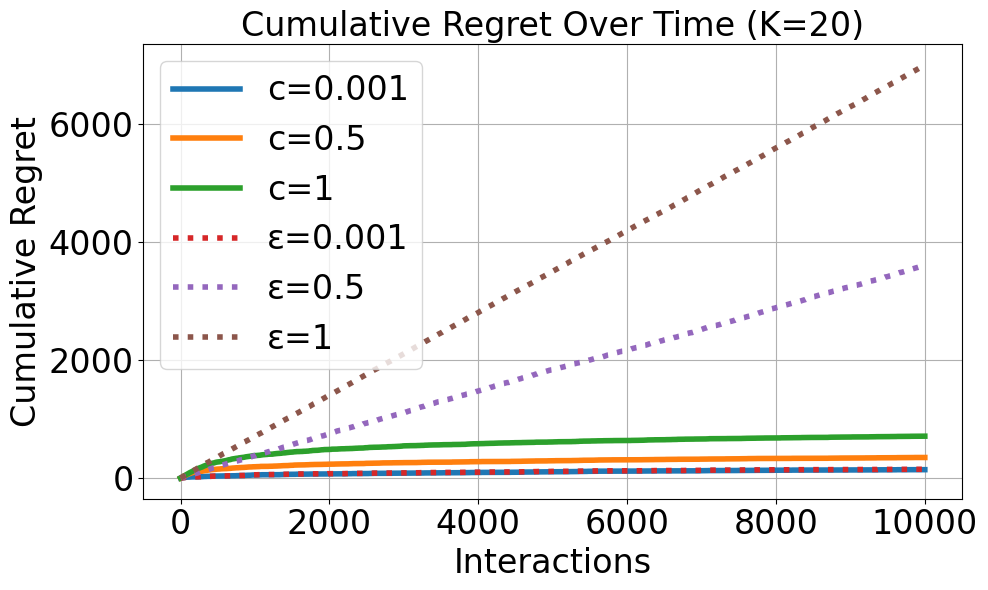

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

for model in model_list:
    regrets = online_regrets[model]
    cumulative_regret = np.cumsum(regrets)

    # Labeling and line style
    if model.__class__.__name__ == "ContextualEpsilonGreedy":
        label = f"ε={model.epsilon}"
        linestyle = ':'  # Dotted line
    else:
        label = f"c={model.alpha}"
        linestyle = '-'  # Solid line

    plt.plot(cumulative_regret, label=label, linestyle=linestyle, linewidth=4)

plt.xlabel("Interactions", fontsize=24)
plt.ylabel("Cumulative Regret", fontsize=24)
plt.tick_params(axis='both', labelsize=24)
plt.title("Cumulative Regret Over Time (K=20)", fontsize=24)
plt.legend(fontsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()